<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/detector_noise_blank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
- reproduce results from `Grob, P., Bean, D., Typke, D., Li, X., Nogales, E., & Glaeser, R. M. (2013). Ranking TEM cameras by their response to electron shot noise. Ultramicroscopy, 133, 1–7. http://doi.org/10.1016/`

# Questions
- dependency on number of pixels ($n \rightarrow \infty$)
- what conclusions can we make for typical electron counting frames?

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def plot(arr):
  plt.imshow(arr,cmap='gray')

In [2]:
%%bash
wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/code/twod.py
wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py
pip install pyfftw

--2020-09-23 23:06:09--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/code/twod.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14832 (14K) [text/plain]
Saving to: ‘twod.py.3’

     0K .......... ....                                       100% 4.19M=0.003s

2020-09-23 23:06:09 (4.19 MB/s) - ‘twod.py.3’ saved [14832/14832]

--2020-09-23 23:06:09--  https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13245 (13K) [text/plain]
Saving to: ‘mrc.py.3’

   

In [3]:
import twod

# Simulate data
assume $B_i^j \sim N(\mu=1,\sigma=\sigma_r)$

In [4]:
nx=1000
n = nx*nx
N0 = 100*n

Njs = np.random.poisson(lam=N0/n,size=n).reshape(nx,nx)

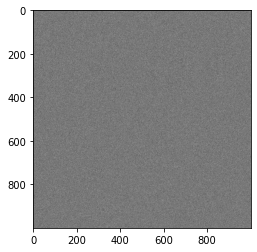

In [6]:
plot(Njs)

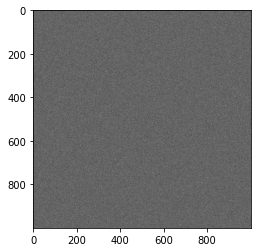

In [5]:
sigma_r = 0.1
Mjs = np.random.normal(loc=Njs,scale=sigma_r*Njs) # because sum of normals is normal (assums Bij is normal)
plot(Mjs)

In [6]:
def sim_data(nx,N0,sigma_r):
  n = nx*nx
  Njs = np.random.poisson(lam=N0/n,size=n).reshape(nx,nx)
  Mjs = np.random.normal(loc=Njs,scale=np.sqrt(sigma_r**2*Njs))
  return(Mjs)
  

# Results 1: $E|F_l|^2 = N_0(1+\sigma_r^2)$

- this means that the noise is independent in Fourier space

Where $F_l = F(\overrightarrow s_l) = \sum_{j=1}^n M_j \exp[i 2 \pi \overrightarrow r_j \cdot \overrightarrow s_l]$ 

## FFT/DFT

In [7]:
def do_fft_numpy(arr):
  '''
  https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft
  X[k] = sum_{i=0}^{n-1} x[i] exp(-i 2 pi m k / n); for k = 0, 1, ..., n-1
  inverse has 1/N and exp(+ i 2 pi mk / n)
  '''
  ftimage = np.fft.fft2(arr)
  ftimage = np.fft.fftshift(ftimage)
  return(ftimage)

np.allclose(np.abs(do_fft_numpy(Mjs)/nx),np.abs(twod.do_fft(Mjs)))

True

In [10]:
import numba

@numba.jit
def do_fft_dft(arr,fft_direction,origin):
  assert fft_direction in ['fft','ifft']
  assert origin in ['top_right', 'origin']

  arr_f = np.zeros(arr.shape,dtype=np.complex64)
  nx,ny = arr.shape
  if origin == 'origin':
    x = np.arange(-nx//2+1,nx//2+1,1)
    y = np.arange(-nx//2+1,nx//2+1,1)
    kx = np.arange(-nx//2+1,nx//2+1,1)
    ky = np.arange(-nx//2+1,nx//2+1,1)
  
  elif origin == 'top_right':
    x = np.arange(nx)
    y = np.arange(nx)
    kx = np.arange(nx)
    ky = np.arange(nx)

  if fft_direction == 'fft':
    pre_comp = -2j*np.pi/nx
  elif fft_direction == 'ifft':
    pre_comp = +2j*np.pi/nx
  
  for kx_idx in range(nx):
      for ky_idx in range(ny):
        for x_idx in range(nx):
          for y_idx in range(ny):
            arr_f[kx_idx,ky_idx] += arr[x_idx,y_idx]*np.exp(pre_comp*(x[x_idx]*kx[kx_idx]+y[y_idx]*ky[ky_idx]))

  if fft_direction == 'ifft':
    pass#arr_f /= arr.size

  return(arr_f)

In [11]:
arr = np.ones((4,4))
np.round(do_fft_dft(arr,fft_direction='fft',origin='origin'),5)

array([[ 0.-0.j,  0.+0.j,  0.+0.j,  0.-0.j],
       [ 0.+0.j, 16.+0.j,  0.-0.j,  0.+0.j],
       [ 0.+0.j,  0.-0.j,  0.+0.j,  0.-0.j],
       [ 0.-0.j,  0.+0.j,  0.-0.j,  0.-0.j]], dtype=complex64)

In [12]:
do_fft_numpy(arr)

array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, 16.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]])

In [13]:
Mjs_f = do_fft_numpy(Mjs)#twod.do_fft(Mjs)


In [14]:
F2 = np.abs(Mjs_f)**2

In [15]:
F2[nx//2,nx//2]

9998771678245938.0

## Many images

In [16]:
n_images = 100
Fs = np.zeros((n_images,nx,nx),dtype=Mjs_f.dtype)
for image_idx in range(n_images):
  Mjs = sim_data(nx,N0,sigma_r)
  Mjs_f = do_fft_numpy(Mjs)
  Fs[image_idx] = Mjs_f


In [17]:
absFs = np.abs(Fs)
E_F2 = (absFs**2).mean(axis=0)
Var_F = absFs.var(axis=0)
VoverE = Var_F/E_F2

In [18]:
np.log(E_F2.mean()), np.log(N0*(1+sigma_r**2)) # with dc component

(23.03593941134191, 18.430631074805532)

In [8]:
def make_dc_mask(nx):
  dc_mask = np.zeros((nx,nx)).astype(np.bool)
  dc_mask[nx//2,nx//2] = True
  return(dc_mask)
dc_mask = make_dc_mask(nx)
E_F2[~dc_mask].mean(), N0*(1+sigma_r**2)
np.log(E_F2[~dc_mask].mean()), np.log(N0*(1+sigma_r**2)) # without dc component

NameError: ignored

(None, 9.33413778017311e-09)

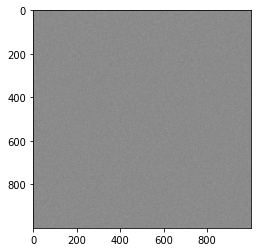

In [20]:
plot(VoverE), VoverE[nx//2,nx//2] # dc component

Is there any frequency dependency in the image?

(<matplotlib.axes._subplots.AxesSubplot at 0x7f738c50ee80>, 0.2124869091587727)

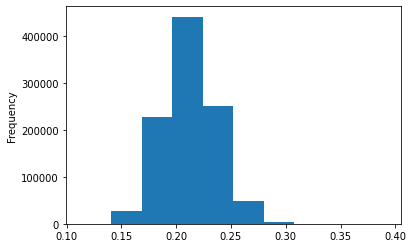

In [21]:
pd.Series(VoverE[~dc_mask].flatten()).plot.hist(), VoverE[~dc_mask].mean()

Are the values close to $1-\pi/4 \approx 0.214_6$?

## 1D

In [9]:
def cmask(index,radius,array,do_ring=False,ring_thickness=1):
  '''
  make a binary circular mask, or ring (variable thickness). 
  '''
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  xxyy = x*x + y*y
  mask = xxyy <= radius*radius
  if do_ring:
    mask_outer = mask
    mask_inner = xxyy <= (radius-ring_thickness)*(radius-ring_thickness)
    mask = np.logical_xor(mask_outer,mask_inner)
  return(mask)

def average_2d(data,mask):
  average = np.nanmean(data[mask])#.mean()
  return(average)

def kernel_2d(kernel,data,radius_step,dtype):
  nx = data.shape[0]
  ring_thickness=radius_step
  radii = range(1,nx//2,ring_thickness)
  twods = np.empty(len(radii), dtype=dtype)
  for i,rad_high in enumerate(radii):
    if rad_high - ring_thickness >=0:
      ring_mask = cmask(index=(nx//2,nx//2),radius=rad_high,array=np.ones_like(data), do_ring=True, ring_thickness=ring_thickness).astype(np.bool)
      twods[i] = kernel(data,ring_mask)
  return(twods)



In [23]:
E_F2_1d = kernel_2d(average_2d,E_F2,1,dtype=E_F2.dtype)
Var_F_1d = kernel_2d(average_2d,Var_F,1,dtype=Var_F.dtype)


In [24]:
E_F2_1d.mean()/n, E_F2[~dc_mask].mean()/n, N0*(1+sigma_r**2)/n

(101.00205750924609, 101.00407311697455, 101.0)

# Result 1.2 $\text{Var}|F_l| \rightarrow N_0(1+\sigma_r^2)(1-\pi/4)$, as
* $N_0 \rightarrow \infty$
* $n \rightarrow \infty$
* $N_0/n \rightarrow C \geq 0$

How large do $N_0$ and $n$ have to be?

In [73]:
nx = 256
n = nx*nx
N0 = .01*n

dc_mask = make_dc_mask(nx)

n_images = 1000
Fs = np.zeros((n_images,nx,nx),dtype=np.complex64)
for image_idx in range(n_images):
  Mjs = sim_data(nx,N0,sigma_r)
  Mjs_f = do_fft_numpy(Mjs)
  #Mjs_f[dc_mask] = np.nan # nan omits dc part
  Fs[image_idx] = Mjs_f

absFs = np.abs(Fs)
E_F2 = (absFs**2).mean(axis=0)
Var_F = np.nanvar(absFs,axis=0)
VoverE = Var_F/E_F2
VoverE[dc_mask] = np.nan # 1d averaging can handle nans
E_F2_1d = kernel_2d(average_2d,E_F2,1,dtype=E_F2.dtype)
Var_F_1d = kernel_2d(average_2d,Var_F,1,dtype=Var_F.dtype)
VoverE_1d = Var_F_1d / E_F2_1d
notes = '2D fft'
print(('|').join(str(x) for x in ['',nx,N0/n,n_images,VoverE[~dc_mask].mean(), VoverE_1d.mean(),notes,'']))

|256|0.01|1000|0.2145687|0.21458851|2D fft|


|nx|N0/n|n_images|EoverV 2D|EoverV averged 1D|notes|
|-|-|-|-|-|-|
|100|100|20|0.20402591 | 0.20484793 |2D fft|
|100|1000|20|0.20483203 | 0.2043736 |2D fft|
|1000|100|20|0.20392857 | 0.20418197 |2D fft|
|1000|1000|20|0.20393603 | 0.2040977 |2D fft|
|2000|1000|20|0.20387016|0.20392041|2D fft|
|256|100|10|0.19282244|-|1D fft. n_images important limit|
|256|100|100|0.21256816|-|1D fft. n_images important limit|
|256|100|1000|0.21441756|-|1D fft. n_images important limit|
|1000|100|10|0.19336814 | 0.19343078 |2D fft|
|1000|100|30|0.20742905 | 0.20745039 |2D fft|
|1000|100|100|0.21236241 | 0.21230318 |2D fft|
|4000|1000|10|0.19315675 | 0.19319282 | 2D fft|
|4000|1000|30|0.20745797 | 0.20748378 | 2D fft|
|4000|1000|100| |  | 2D fft|
|256|1000|30|0.20755266 | 0.20875886 |2D fft|
|256|1000|100|0.21263933 | 0.2128421 |2D fft|
|256|1000|300| 0.21381788 | 0.21370117 |2D fft|
|256|1000|1000|0.21434464 | 0.2142799 |2D fft|
|256|1000|3000| 0.21458246 | 0.21462609 |2D fft|
|128|1000|3000| 0.2146094 | 0.21461609 |2D fft|
|128|1000|10k| 0.21457648 | 0.21448629 |2D fft|
|128|1000|30k| 0.21462664 | 0.21463741 |2D fft|
|64|1000|1000|0.21442802 | 0.21462353 |2D fft|
|64|1|1000|0.21459538 | 0.21414857 |2D fft|
|64|.1|1000|0.21464537 | 0.21449448 |2D fft|
|64|.01|1000|0.21690616 | 0.21640952 |2D fft|
|64|.001|1000|0.24470001 | 0.24510117 |2D fft|
|64|.0001|1000|0.6869852 | 0.68712145 |2D fft|
|128|10|1000|0.2145016 | 0.21466172 |2D fft|
|128|1|1000|0.21440125 | 0.21438721 |D fft|
|128|.1|1000|0.21432382 | 0.21433103 |2D fft|
|128|.01|1000|0.2150657 | 0.21502042 |2D fft|
|128|0.001|1000|0.2203666|0.2202864|2D fft|
|128|0.0001|1000|0.34576812|0.345726|2D fft|
|256|.1|1000|0.2144125 | 0.21434918 |2D fft|
|256|.01|1000|0.21457301 | 0.21457437 |2D fft|
|256|.001|1000|0.21574154 | 0.21580866 |2D fft|
|256|.0001|1000|0.23186098 | 0.23187168 |2D fft|
|256|.00001|1000|0.57673883 | 0.576805 |2D fft|



Does this agree with the analytical result $(1-\pi/4 = 0.21460183_7)$?

In [204]:
1-np.pi/4

0.21460183660255172

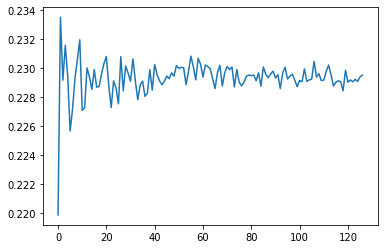

In [72]:
pd.Series(VoverE_1d).plot()

# Electron Counts

In [96]:
nx = 256
n = nx*nx
N0 = .01*n
sigma_r = 0

dc_mask = make_dc_mask(nx)

n_images = 2
Fs = np.zeros((n_images,nx,nx),dtype=np.complex64)
for image_idx in range(n_images):
  Mjs = sim_data(nx,N0,sigma_r)
  Mjs_f = do_fft_numpy(Mjs)
  #Mjs_f[dc_mask] = np.nan # nan omits dc part
  Fs[image_idx] = Mjs_f

absFs = np.abs(Fs)
E_F2 = (absFs**2).mean(axis=0)
Var_F = np.nanvar(absFs,axis=0)
VoverE = Var_F/E_F2
VoverE[dc_mask] = np.nan # 1d averaging can handle nans
E_F2_1d = kernel_2d(average_2d,E_F2,1,dtype=E_F2.dtype)
Var_F_1d = kernel_2d(average_2d,Var_F,1,dtype=Var_F.dtype)
VoverE_1d = Var_F_1d / E_F2_1d
notes = '2D fft'
print(('|').join(str(x) for x in ['',nx,N0/n,n_images,VoverE[~dc_mask].mean(), VoverE_1d.mean(),notes,'']))

|256|0.01|2|0.107369|0.10729809|2D fft|


|nx|N0/n|n_images|EoverV 2D|EoverV averged 1D|notes|
|-|-|-|-|-|-|
|256|0.01|1000|0.21459647|0.21464027|2D fft|
|256|0.01|300|0.21392|0.21383025|2D fft|
|256|0.01|100|0.21246256|0.21257499|2D fft|
|256|0.01|30|0.20739408|0.20754619|2D fft|
|256|0.01|10|0.1937519|0.19319715|2D fft|
|256|0.01|3|0.14224592|0.14245377|2D fft|
|256|0.01|2|0.107369|0.10729809|2D fft|

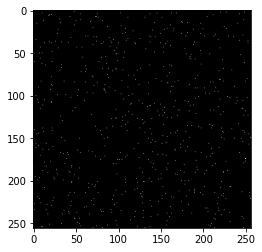

In [90]:
plot(Mjs)

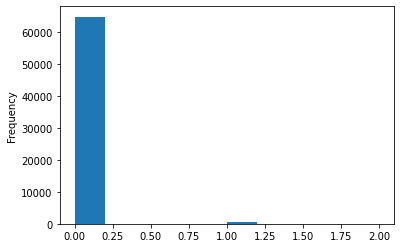

In [91]:
pd.Series(Mjs.flatten()).plot.hist()

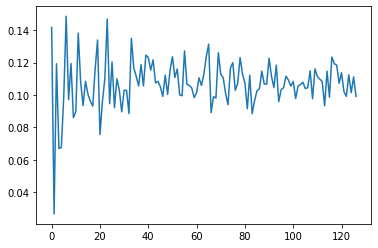

In [97]:
pd.Series(VoverE_1d).plot()